# Initial Setup

In [2]:
%%capture
%load_ext autoreload
%autoreload 2

import tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import quandl

from IPython.display import Audio
sound_file = '../sound/done.mp3'

import tbats
import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.units as munits
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from regressions import *
from Pmdarima_Model import Pmdarima_Model

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[date] = converter
munits.registry[datetime] = converter

from keys import client_id, secret_key, av_key, consumer_key, api_key

## Get NYSE calendar

In [3]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [4]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [5]:
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# YFinance Futures

## Setup / Gather Data

In [6]:
symbol = 'SPY'
f_symbol = 'ES=F'

In [7]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

In [8]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, f_symbol, freq=CBD, fut=True)

In [9]:
# spy_f_df = yf.download(symbol, start='2011-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_10Y_CBD.csv')

## Load Data from File

### 3Y

In [10]:
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_f_df_3Y = load_yf_time_series(yf, 3, f_symbol, freq=CBD)

### 5Y

In [11]:
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_f_df_5Y = load_yf_time_series(yf, 5, f_symbol, freq=CBD)

### 10Y

In [12]:
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_f_df_10Y = load_yf_time_series(yf, 10, f_symbol, freq=CBD)

In [13]:
# spy_df_10Y = pd.read_csv('../data/SPY_10Y_CBD.csv', index_col='date')
# spy_df_10Y.index = pd.to_datetime(spy_df_10Y.index)

In [14]:
# spy_f_df_10Y = pd.read_csv('../data/SPY_F_10Y_CBD.csv', index_col='date')
# spy_f_df_10Y.index = pd.to_datetime(spy_f_df_10Y.index)

### All

In [15]:
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)
spy_f_df_all = load_yf_time_series(yf, 30, f_symbol, freq=CBD)

### Treasury Yield Curve

In [16]:
# tsy_df = pd.read_csv('../data/10-year-treasury-bond-rate-yield-chart.csv', index_col='date')
# tsy_df.dropna(inplace=True)
# tsy_df.index = pd.to_datetime(tsy_df.index)
# tsy_df.columns = ['value']

In [17]:
# tsy_all_df = tsy_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
# tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Using Quandl

In [88]:
tsy_symbol = 'USTREASURY/YIELD'

In [89]:
tsy_df = quandl.get(tsy_symbol)
tsy_all_df = tsy_df.copy()
tsy_all_df.index.name = 'date'

In [90]:
tsy_all_df = tsy_all_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [91]:
tsy_all_df.isna().sum()

1 MO     2130
2 MO     6435
3 MO        3
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR     170
30 YR     994
dtype: int64

In [92]:
tsy_3Y_df = tsy_3Y_df.asfreq(CBD).interpolate()
tsy_5Y_df = tsy_5Y_df.asfreq(CBD).interpolate()
tsy_10Y_df = tsy_10Y_df.asfreq(CBD).interpolate()
tsy_all_df = tsy_all_df.asfreq(CBD).interpolate()

In [93]:
tsy_all_df_6M = tsy_all_df['6 MO']
tsy_all_df_1Y = tsy_all_df['1 YR']
tsy_all_df_2Y = tsy_all_df['2 YR']
tsy_all_df_3Y = tsy_all_df['3 YR']
tsy_all_df_5Y = tsy_all_df['5 YR']
tsy_all_df_7Y = tsy_all_df['7 YR']
tsy_all_df_10Y = tsy_all_df['10 YR']

In [94]:
tsy_3Y_df_10Y = tsy_3Y_df['3 YR']

In [24]:
tsy_all_df.isna().sum()

1 MO     2146
2 MO     6476
3 MO        0
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR     170
30 YR       0
dtype: int64

In [29]:
tsy_all_df_10Y

date
1993-01-29    6.39
1993-02-01    6.38
1993-02-02    6.46
1993-02-03    6.45
1993-02-04    6.39
              ... 
2021-05-03    1.63
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
Freq: C, Name: 10 YR, Length: 7120, dtype: float64

In [32]:
tsy_all_df_10Y.corr(spy_df_all.close)

-0.7378211753819259

In [33]:
tsy_df['1 MO'].corr(spy_df_all.close)

-0.12841828429783703

In [34]:
tsy_df['2 MO'].corr(spy_df_all.close)

-0.6636368753299257

In [35]:
tsy_df['3 MO'].corr(spy_df_all.close)

-0.4305219266092625

In [36]:
tsy_df['6 MO'].corr(spy_df_all.close)

-0.4406860977866312

In [37]:
tsy_df['1 YR'].corr(spy_df_all.close)

-0.4652689385108235

In [38]:
tsy_df['2 YR'].corr(spy_df_all.close)

-0.5133047857291233

In [39]:
tsy_df['3 YR'].corr(spy_df_all.close)

-0.5540569598652841

In [40]:
tsy_df['5 YR'].corr(spy_df_all.close)

-0.6293462711352416

In [41]:
tsy_df['7 YR'].corr(spy_df_all.close)

-0.6793272992648908

In [46]:
tsy_df['10 YR']

Date
1990-01-02    7.94
1990-01-03    7.99
1990-01-04    7.98
1990-01-05    7.99
1990-01-08    8.02
              ... 
2021-05-03    1.63
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
Name: 10 YR, Length: 7844, dtype: float64

In [43]:
tsy_df['10 YR'].corr(spy_df_all.close)

-0.7377688660627081

In [44]:
tsy_df['20 YR'].corr(spy_df_all.close)

-0.7900510993214253

In [45]:
tsy_df['30 YR'].corr(spy_df_all.close)

-0.8176721314971296

#### Inflation Indexed

In [47]:
tsy_ii_symbol = 'FRED/DFII10'
tsy_ii_df = quandl.get(tsy_ii_symbol)
tsy_ii_df

,Value
Date,
2003-01-02,2.43
2003-01-03,2.43
2003-01-06,2.46
2003-01-07,2.42
2003-01-08,2.29
...,...
2021-04-30,-0.76
2021-05-03,-0.79
2021-05-04,-0.81


### Fed Funds Rate

In [ ]:
# fed_df = pd.read_csv('../data/fed-funds-rate-historical-chart.csv', index_col='date')
# fed_df.dropna(inplace=True)
# fed_df.index = pd.to_datetime(fed_df.index)
# fed_df.columns = ['value']

In [ ]:
# fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
# fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Quandl

In [ ]:
# fed_symbol = 'FRED/FEDFUNDS'
fed_symbol_daily = 'FRED/DFF'
# fed_df = quandl.get(fed_symbol)
fed_df = quandl.get(fed_symbol_daily)
fed_df = fed_df.Value
fed_df.index.name = 'date'
fed_df.name = 'value'
fed_df.isna().sum()

In [140]:
fed_df

date
1954-07-01    1.13
1954-07-02    1.25
1954-07-03    1.25
1954-07-04    1.25
1954-07-05    0.88
              ... 
2021-05-02    0.05
2021-05-03    0.06
2021-05-04    0.06
2021-05-05    0.06
2021-05-06    0.06
Name: value, Length: 24417, dtype: float64

In [149]:
fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [150]:
fed_all_df = fed_all_df.asfreq(CBD)
fed_10Y_df = fed_10Y_df.asfreq(CBD)
fed_5Y_df = fed_5Y_df.asfreq(CBD)
fed_3Y_df = fed_3Y_df.asfreq(CBD)

In [130]:
fed_all_df.isna().sum(), fed_10Y_df.isna().sum(), fed_5Y_df.isna().sum(), fed_3Y_df.isna().sum()

(value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64)

## Data Preparation

### EDA

In [55]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246


In [56]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [65]:
tsy_3Y_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
date,,,,,,,,,,,,
2018-05-01,1.68,NaN,1.85,2.05,2.26,2.50,2.66,2.82,2.93,2.97,3.03,3.13
2018-05-02,1.69,NaN,1.84,2.03,2.24,2.49,2.64,2.80,2.92,2.97,3.04,3.14
2018-05-03,1.68,NaN,1.84,2.02,2.24,2.49,2.62,2.78,2.90,2.94,3.02,3.12
2018-05-04,1.67,NaN,1.84,2.03,2.24,2.51,2.63,2.78,2.90,2.95,3.02,3.12
2018-05-07,1.69,NaN,1.86,2.05,2.25,2.49,2.64,2.78,2.90,2.95,3.02,3.12
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,0.02,0.02,0.04,0.04,0.06,0.16,0.33,0.84,1.29,1.63,2.18,2.30
2021-05-04,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.82,1.28,1.61,2.16,2.27
2021-05-05,0.01,0.01,0.02,0.04,0.06,0.16,0.32,0.80,1.25,1.59,2.14,2.25


In [125]:
df_3Y_close

date
2018-05-01    264.980011
2018-05-02    263.200012
2018-05-03    262.619995
2018-05-04    266.019989
2018-05-07    266.920013
                 ...    
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
Freq: C, Name: close, Length: 761, dtype: float64

In [126]:
df_f_3Y_close

date
2018-05-01    2652.25
2018-05-02    2627.50
2018-05-03    2631.75
2018-05-04    2663.00
2018-05-07    2670.00
               ...   
2021-05-03    4185.75
2021-05-04    4158.25
2021-05-05    4160.00
2021-05-06    4194.25
2021-05-07    4225.25
Freq: C, Name: f_close, Length: 761, dtype: float64

In [127]:
tsy_3Y_df_10Y

date
2018-05-01    2.66
2018-05-02    2.64
2018-05-03    2.62
2018-05-04    2.63
2018-05-07    2.64
              ... 
2021-05-03    0.33
2021-05-04    0.33
2021-05-05    0.32
2021-05-06    0.32
2021-05-07    0.29
Freq: C, Name: 3 YR, Length: 761, dtype: float64

In [148]:
fed_3Y_df

,value
date,
2018-05-01,1.70
2018-05-02,1.70
2018-05-03,1.70
2018-05-04,1.70
2018-05-07,1.70
...,...
2021-04-30,0.05
2021-05-03,0.06
2021-05-04,0.06


In [152]:
kwargs = {'data':[df_3Y_close, df_f_3Y_close, tsy_3Y_df_10Y, fed_3Y_df]}

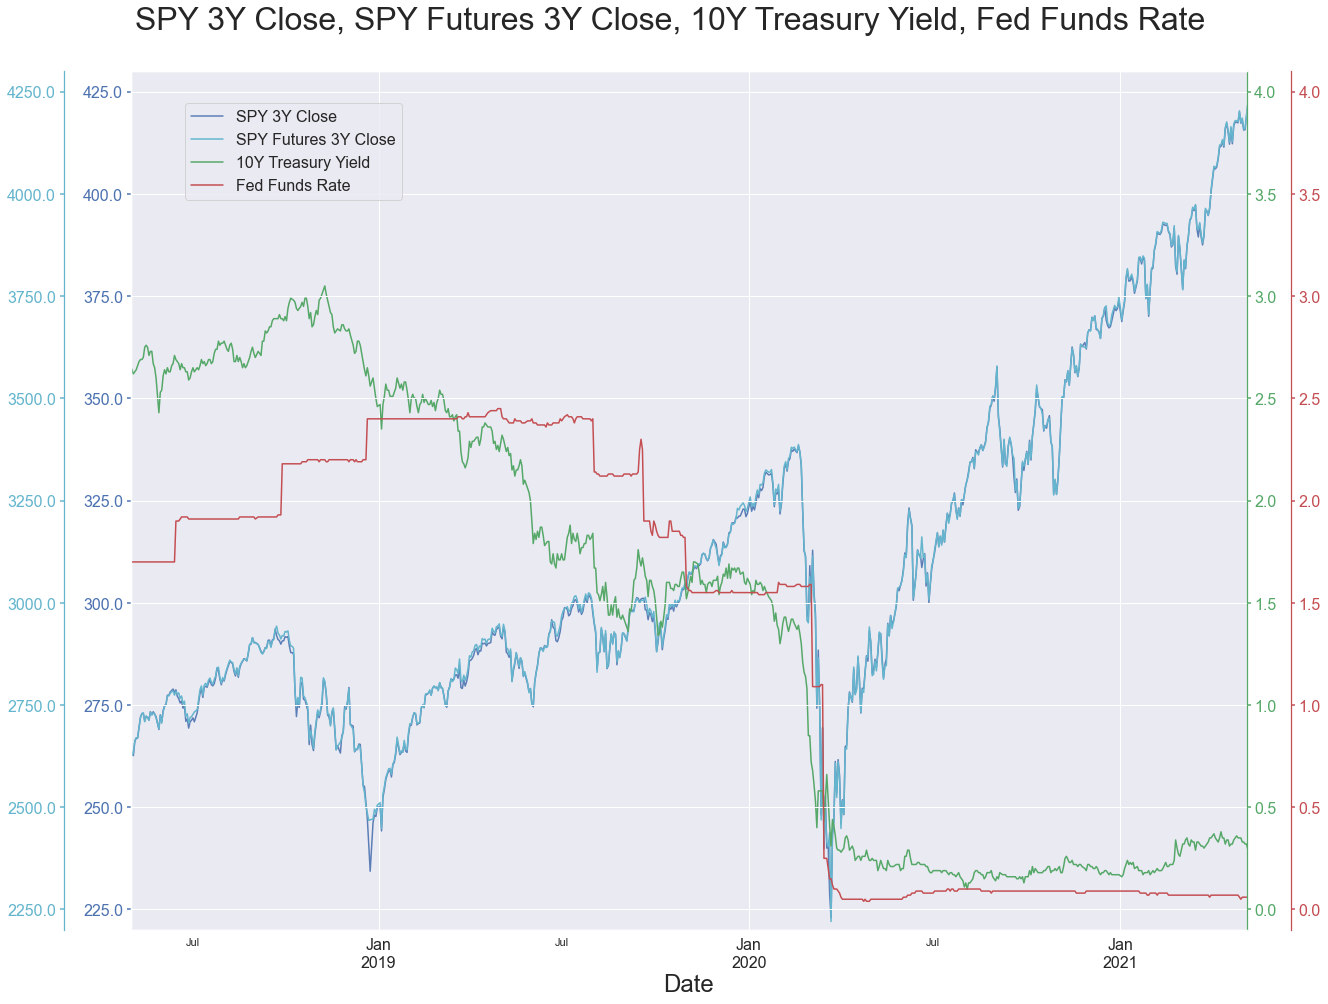

In [153]:
plot_spy_fut_tsy_funds_time_series(**kwargs)

In [ ]:
# fig, ax1 = plt.subplots(figsize=(20,15))
# axes = [ax1, ax2, ax3, ax4]
# data = [spy_df_3Y.close, spy_f_df_3Y.f_close, tsy_3Y_df.value, fed_3Y_df.value]
# colors = ['b','c','g','r']
# labels = ['SPY 3Y Close', 'SPY Futures 3Y Close', '10Y Treasury Yield', 'Fed Funds Rate']
# ylabels = ['SPY 3Y Close (USD)', 'SPY Futures 3Y Close (USD)', '10Y Treasury Yield %', 'Fed Funds Rate %']
# alpha = [0.9, 1, 1, 1]
# spy_range = (225, 425)
# yield_range = (0, 4)
# num_ticks = 9
# y_ranges = [spy_range, [10*x for x in spy_range], yield_range, yield_range]
# tkw = dict(size=4, width=1.5, labelsize=16)
# for n, ax in enumerate(axes):
#     if n>0:
#         ax = ax1.twinx()
#     if n==1:
#         ax.spines['left'].set_position(("axes", -0.06))
#         ax.spines['left'].set_edgecolor(colors[n])
#         ax.yaxis.set_label_position("left")
#         ax.yaxis.tick_left()
#     if n>1:
#         ax.spines['right'].set_position(("axes", 1 + 0.04*(n-2)))
#         ax.spines['right'].set_edgecolor(colors[n])
#     data[n].plot(ax=ax, color=colors[n], alpha=alpha[n], label=labels[n])
#     y_ticks = np.linspace(y_ranges[n][0], y_ranges[n][1], num_ticks)
#     pad = (y_ranges[n][1] - y_ranges[n][0]) / (num_ticks-1)/5
#     y_lim = (y_ranges[n][0]-pad, y_ranges[n][1]+pad)
#     ax.set_yticklabels(y_ticks)
#     ax.set_yticks(y_ticks)
#     ax.set_ylim(y_lim)
#     ax.tick_params(axis='y', colors=colors[n], **tkw)

# ax1.set_xlabel('Date', size=24)
# ax1.tick_params(axis='x', **tkw)
# fig.suptitle(', '.join(labels), size=32)
# fig.subplots_adjust(top=0.92)
# fig.legend(loc=(0.139, 0.8007), prop={"size":16})
# plt.savefig(f'{TOP}/images/SPY_3Y_Comparison_Graph.png')
# # fig.legend(loc='upper left', borderaxespad=7)

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,15))
spy_df_3Y.close.plot(ax=ax1, color ='b', label='SPY 3Y Close')
ax1.tick_params(axis='y', colors='b')
ax1.set_ylim(x1_range)
x1_range = (200,425)
ax1.set_yticklabels(np.arange(x1_range[0],x1_range[1],11))

ax2 = ax1.twinx()
spy_f_df_3Y.f_close.plot(ax=ax2, color = 'r', label='SPY Futures 3Y Close')
ax2.tick_params(axis='y', colors='r')
x2_range = (2000,4250)
ax2.set_yticklabels(np.arange(x2_range[0],x2_range[1],11))

ax3 = ax1.twinx()
tsy_3Y_df.value.plot(ax=ax3, color = 'g', label='10Y Treasury Yield')
ax3.tick_params(axis='y', colors='g')

ax4 = ax1.twinx()
fed_3Y_df.value.plot(ax=ax4, color = 'darkorange', label='Fed Funds Rate')
ax4.tick_params(axis='y', colors='darkorange')
ax4.set_ylim(-0.05, 2.55)

fig.suptitle('SPY Closing, SPY Futures Close, 10Y Treasury Yield, Fed Funds Rate', size=24)
fig.subplots_adjust(top=0.95)
fig.legend(loc=(0.65, 0.85))

In [ ]:
spy_df_3Y

In [ ]:
spy_df_5Y

In [ ]:
spy_df_3Y.index[-1]

In [ ]:
spy_df_5Y.truncate(before=spy_df_3Y.index[0])

### Set up Frequency

In [114]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [118]:
spy_f_df_3Y = spy_f_df_3Y.asfreq(CBD)
spy_f_df_5Y = spy_f_df_5Y.asfreq(CBD)
spy_f_df_10Y = spy_f_df_10Y.asfreq(CBD)
spy_f_df_all = spy_f_df_all.asfreq(CBD)

In [117]:
spy_df_all.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [116]:
spy_f_df_all.isna().sum().inte

f_open         35
f_high         35
f_low          35
f_close        35
f_adj_close    35
f_volume       35
dtype: int64

In [ ]:
tsy_df = tsy_df.asfreq(CBD)

In [ ]:
tsy_df[tsy_df['10 YR'].isna()]['10 YR']

In [ ]:
spy_df_3Y.isna().sum(), spy_df_5Y.isna().sum(), spy_df_10Y.isna().sum(), spy_df_25Y.isna().sum()

In [ ]:
spy_f_df_5Y[spy_f_df_5Y.f_close.isna()]

### Impute Missing Values

In [120]:
spy_f_df_3Y = spy_f_df_3Y.interpolate()
spy_f_df_5Y = spy_f_df_5Y.interpolate()
spy_f_df_10Y = spy_f_df_10Y.interpolate()
spy_f_df_all = spy_f_df_all.interpolate()

### Create Time Series for `Close`, `Volume`

In [124]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.volume
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.volume
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.volume
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.volume

df_f_3Y_close = spy_f_df_3Y.f_close
df_f_3Y_vol = spy_f_df_3Y.f_volume
df_f_5Y_close = spy_f_df_5Y.f_close
df_f_5Y_vol = spy_f_df_5Y.f_volume
df_f_10Y_close = spy_f_df_10Y.f_close
df_f_10Y_vol = spy_f_df_10Y.f_volume
df_f_all_close = spy_f_df_all.f_close
df_f_all_vol = spy_f_df_all.f_volume

In [123]:
df_f_5Y_close, df_f_5Y_vol

(date
 2016-05-02    2074.25
 2016-05-03    2057.00
 2016-05-04    2047.00
 2016-05-05    2044.00
 2016-05-06    2052.75
                ...   
 2021-05-03    4185.75
 2021-05-04    4158.25
 2021-05-05    4160.00
 2021-05-06    4194.25
 2021-05-07    4225.25
 Freq: C, Name: f_close, Length: 1264, dtype: float64,
 date
 2016-05-02    1306173.0
 2016-05-03    1827577.0
 2016-05-04    1557981.0
 2016-05-05    1433289.0
 2016-05-06    1813432.0
                 ...    
 2021-05-03    1256240.0
 2021-05-04    2003587.0
 2021-05-05    1418246.0
 2021-05-06    1751616.0
 2021-05-07    1751616.0
 Freq: C, Name: f_volume, Length: 1264, dtype: float64)

## Data Exploration

### Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



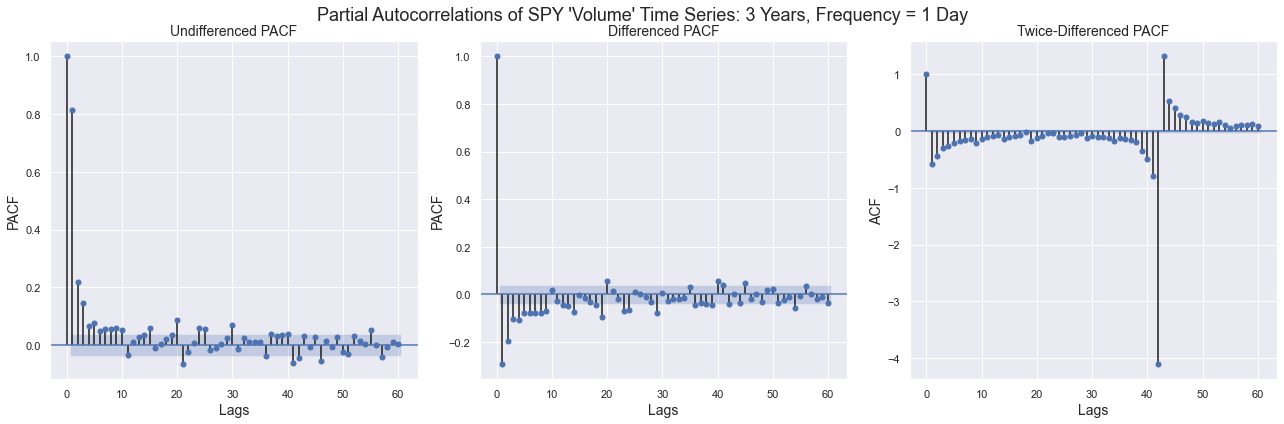

In [351]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

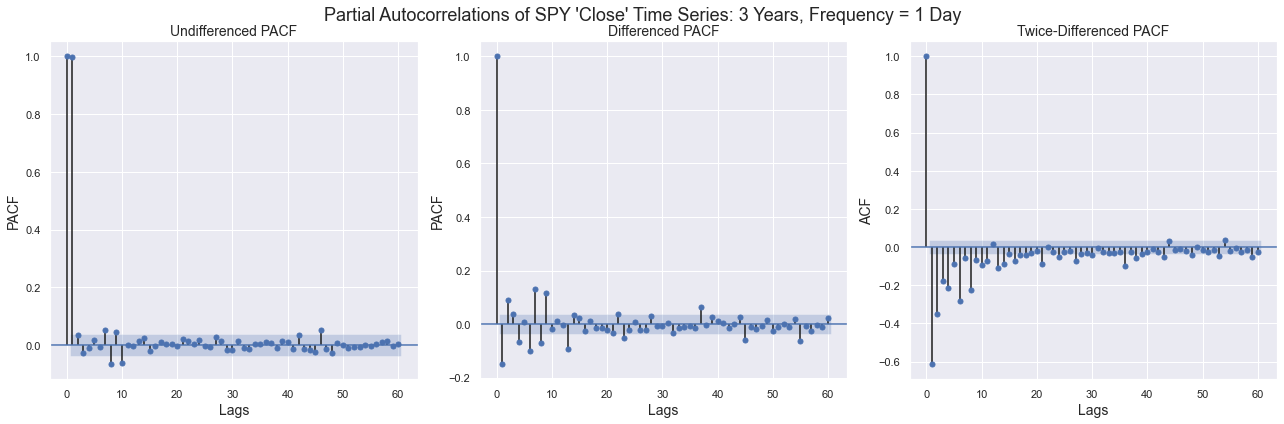

In [352]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

### Plot ACF

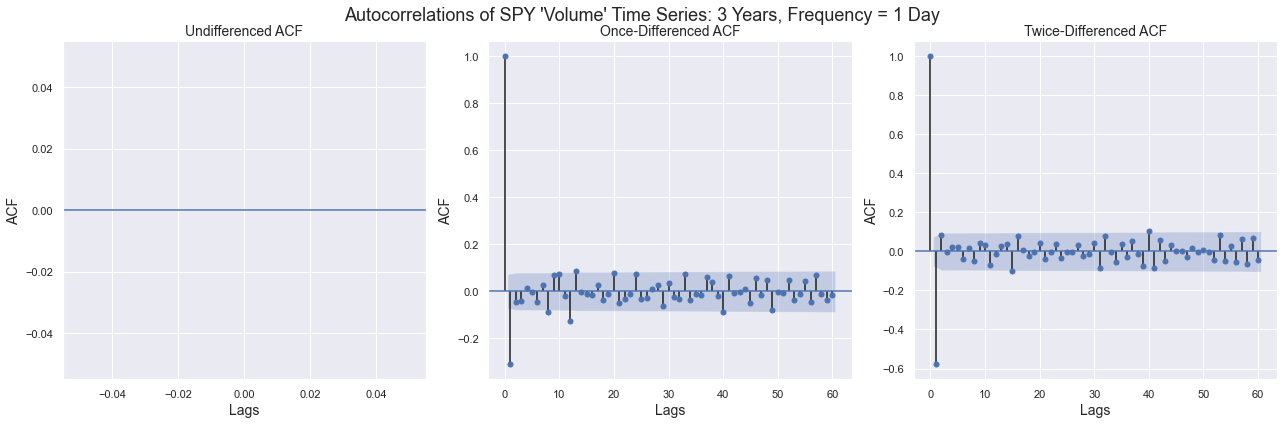

In [21]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

In [1]:
plot_acf_with_diff(df_full_all_close, 'SPY \'Close\'', 28, 'years', '1 Day', lags=60)

NameError: name 'plot_acf_with_diff' is not defined

### Plot Seasonal Decomposition

#### 3 Years, Freq = Custom Business Day, Yearly Seasonality

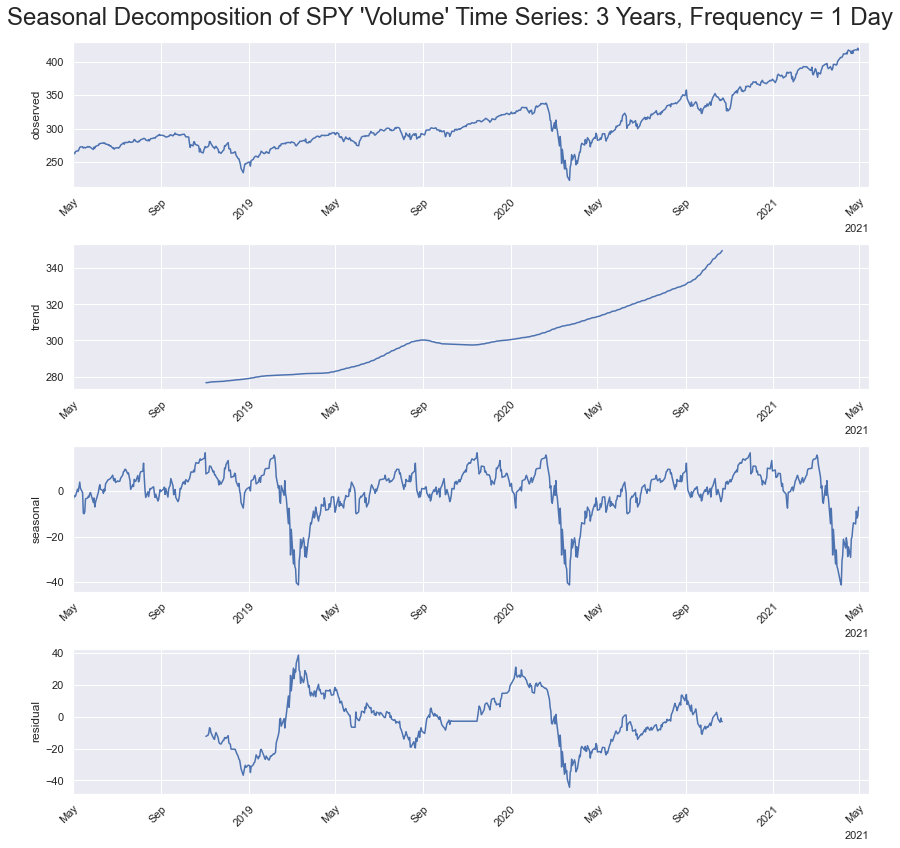

In [23]:
plot_seasonal_decomposition(df_full_3Y_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

#### 5 Years, Freq = Custom Business Day, Yearly Seasonality

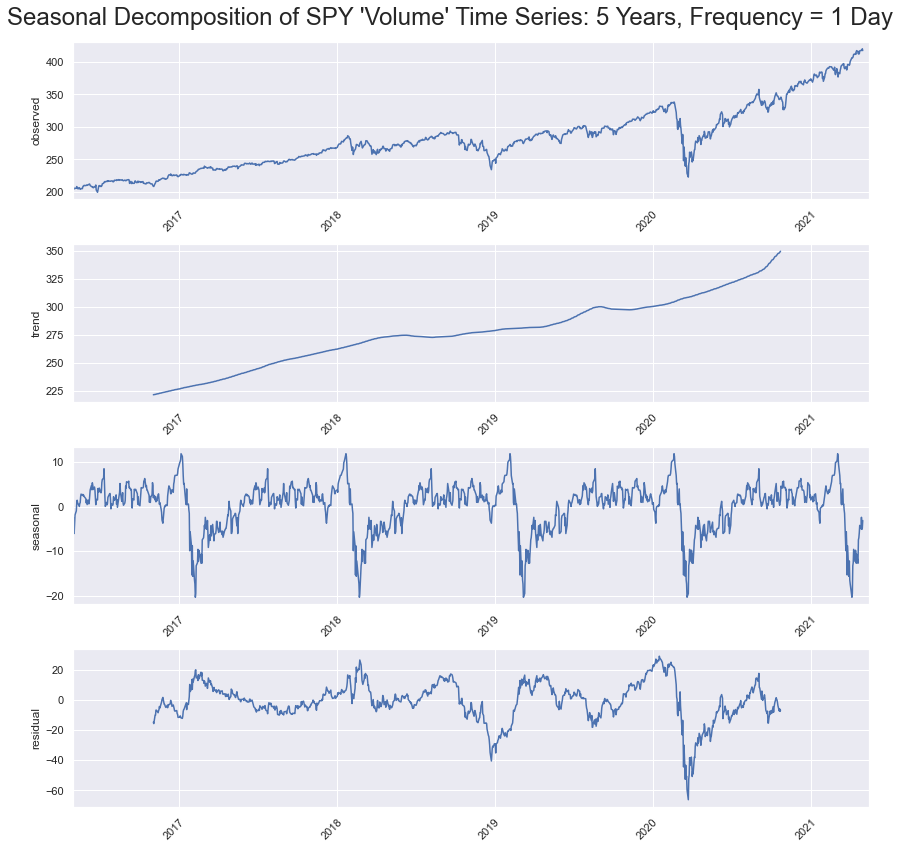

In [24]:
plot_seasonal_decomposition(df_full_5Y_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 261)

#### 10 Years, Freq = Custom Business Day, Yearly Seasonality

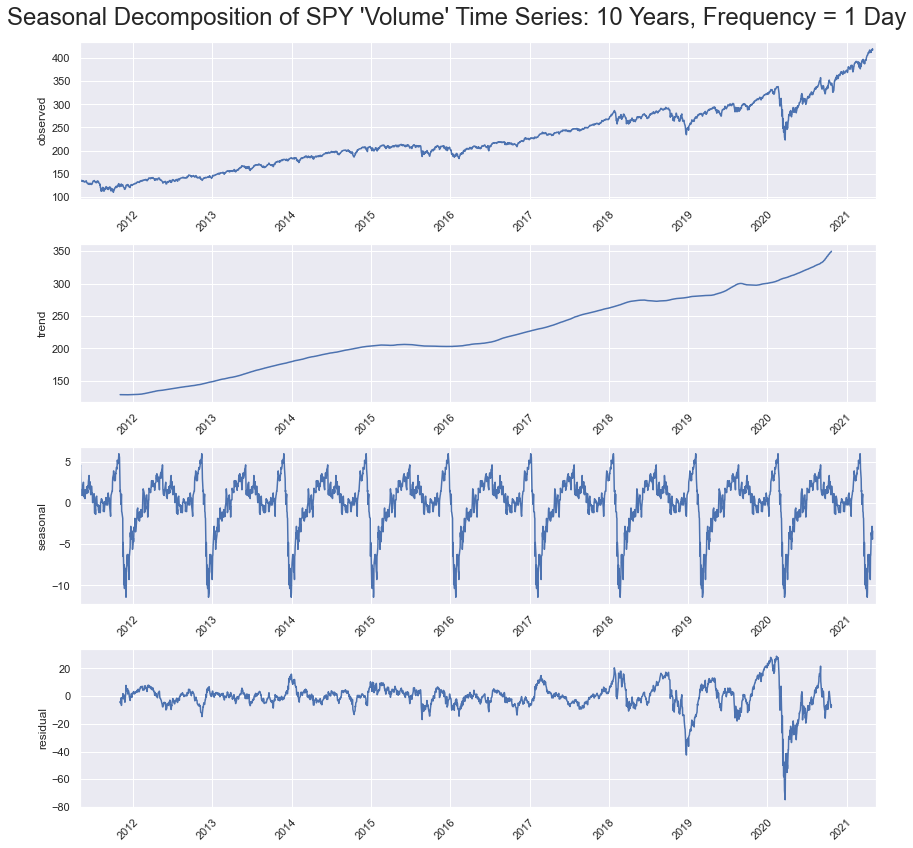

In [25]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

### Build DF combining SPY and SPY F

In [43]:
spy_cat_3Y_df = spy_df_3Y.join(spy_f_df_3Y)
spy_cat_3Y_df

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


### Build DF combining the two with one day offset

In [38]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [39]:
spy_f_df_3Y_1d_back = spy_f_df_3Y.copy()
spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+CBD
# spy_f_df_3Y_1d_back.drop(spy_f_df_3Y_1d_back.index[-1], axis=0, inplace=True)
spy_f_df_3Y_1d_back

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [40]:
df_1d_back = spy_df_3Y.copy()
df_1d_back = spy_f_df_3Y_1d_back.join(df_1d_back)
df_1d_back

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,open,high,low,close,adj_close,volume
date,,,,,,,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0,266.500000,267.329987,265.149994,266.920013,252.547226,67499200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0,416.070007,416.600006,411.670013,415.619995,415.619995,101591200.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0,417.380005,417.630005,415.149994,415.750000,415.750000,39960700.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0,415.829987,419.209991,413.679993,419.070007,419.070007,74321400.0


### Create Diffs DF

In [44]:
spy_cat_3Y_df_diff = pd.DataFrame(index = spy_cat_3Y_df.index)

In [45]:
spy_cat_3Y_df_diff['d_close'] = spy_cat_3Y_df.close.diff()
spy_cat_3Y_df_diff['d_f_close'] = spy_cat_3Y_df.f_close.diff()
spy_cat_3Y_df_diff['d_open'] = spy_cat_3Y_df.open.diff()
spy_cat_3Y_df_diff['d_f_open'] = spy_cat_3Y_df.f_open.diff()

In [46]:
spy_cat_3Y_df_diff

,d_close,d_f_close,d_open,d_f_open
date,,,,
2018-05-01,NaN,NaN,NaN,NaN
2018-05-02,-1.779999,-24.75,0.890015,9.25
2018-05-03,-0.580017,4.25,-2.500000,-28.75
2018-05-04,3.399994,31.25,-0.740021,5.00
2018-05-07,0.900024,7.00,5.370026,31.00
...,...,...,...,...
2021-05-03,0.900024,11.25,1.799988,-19.25
2021-05-04,-2.580017,-27.50,-3.359985,2.75
2021-05-05,0.130005,1.75,1.309998,-26.00


In [47]:
spy_df_10Y.shape[0]/10

252.2

### Check Correlations between SPY and SPY Futures

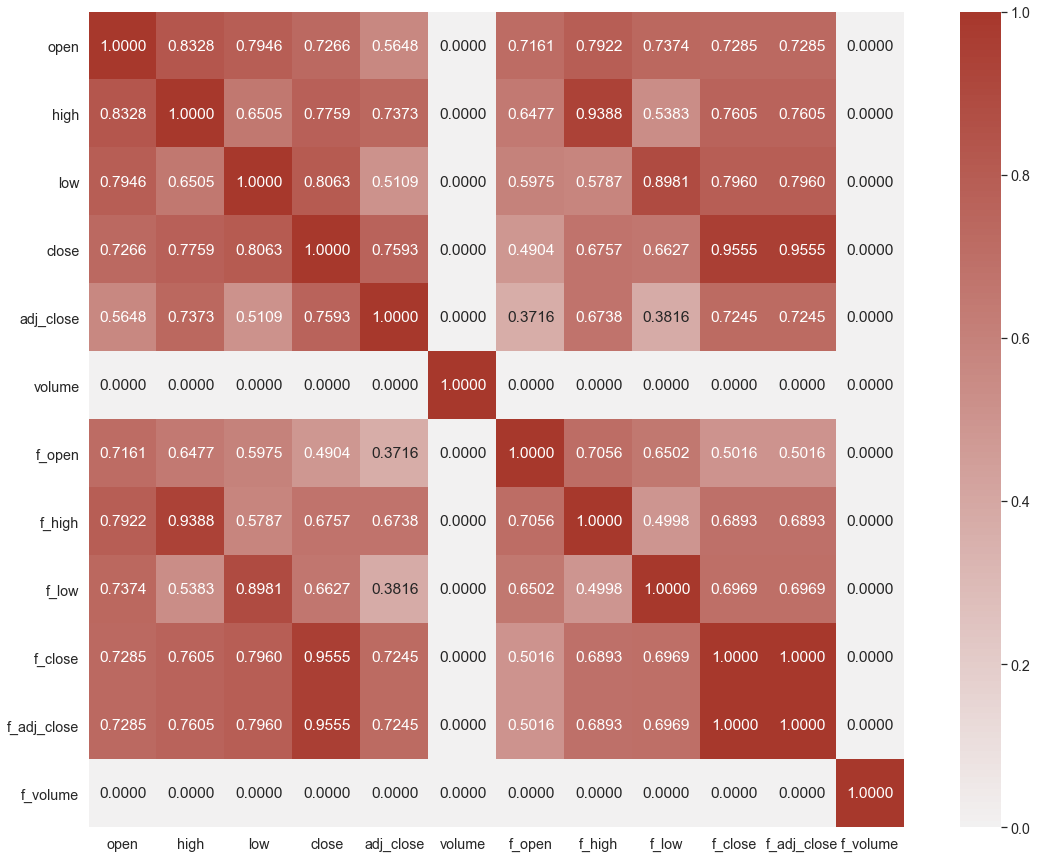

In [50]:
matrix = spy_cat_3Y_df.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**150, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

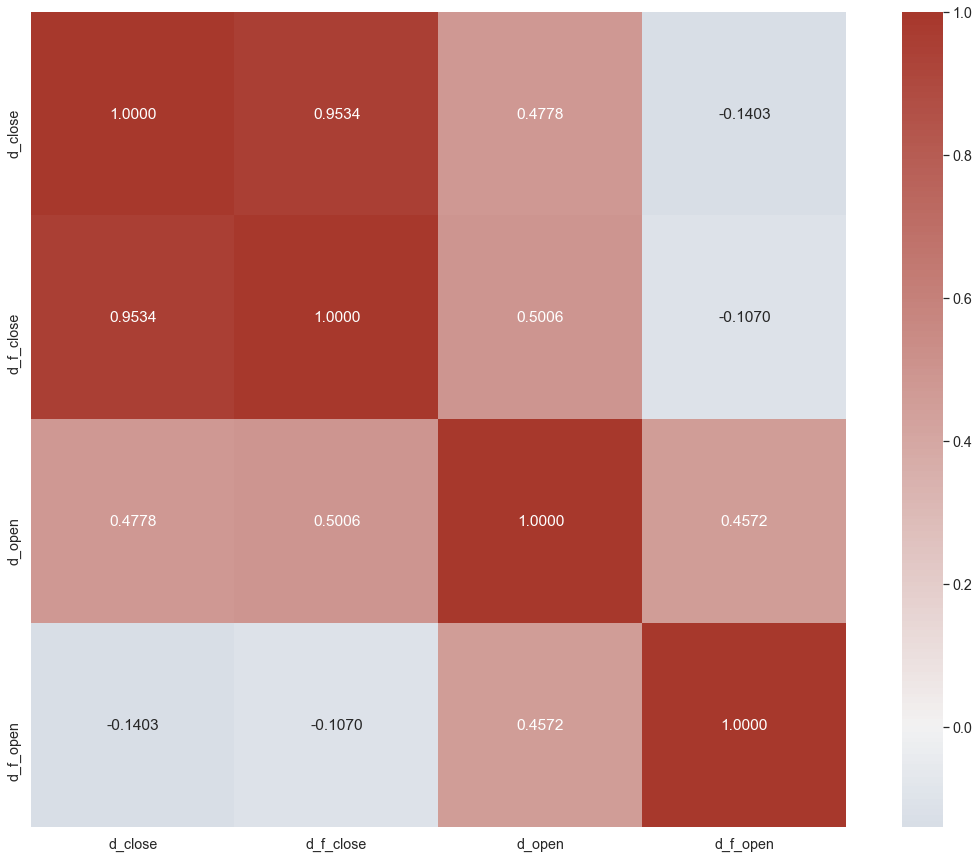

In [51]:
matrix = spy_cat_3Y_df_diff.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

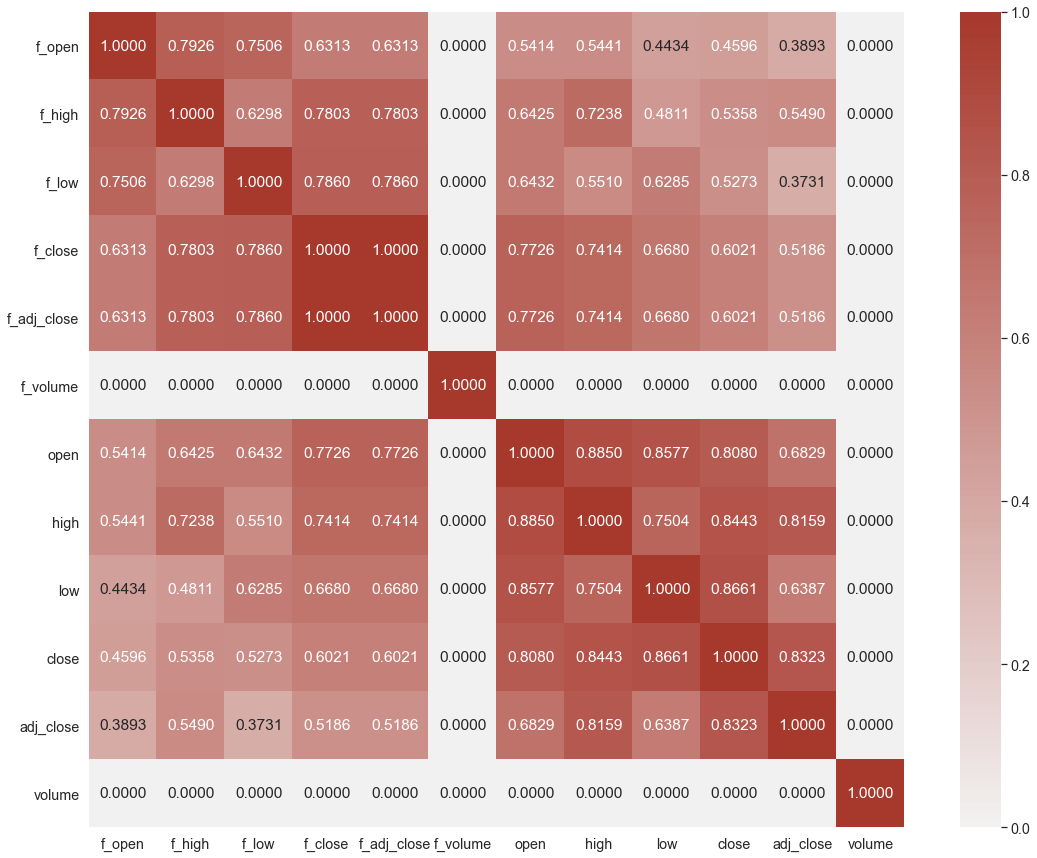

In [52]:
matrix = df_1d_back.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**100, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

# Modeling

## pmdarima

### Treasury Exogenous Variables

In [111]:
tsy_all_df_10Y.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07'],
              dtype='datetime64[ns]', name='date', length=7120, freq='C')

In [156]:
pam_tsy_all_10Y.conf_ints;

#### 3Y

In [159]:
pam_tsy_3Y_10Y = Pmdarima_Model(tsy_3Y_df_10Y, 'TSY 10Y Note',
               n=3, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


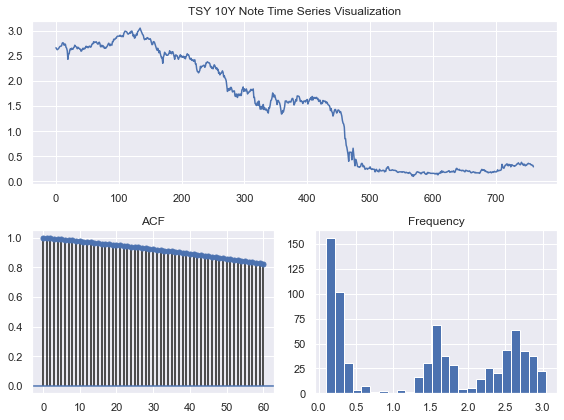

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2135.476, Time=0.77 sec
First viable model found (-2135.476)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2137.169, Time=0.41 sec
New best model found (-2137.169 < -2135.476)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2135.581, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2135.534, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2133.114, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2133.627, Time=0.87 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.573 seconds
Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3

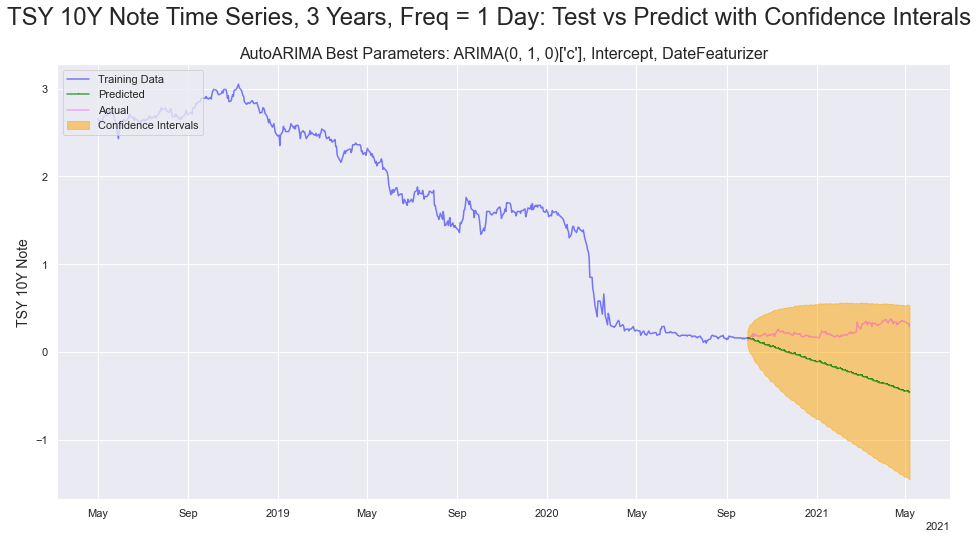

In [160]:
pam_tsy_3Y_10Y_AA_pipe = pam_tsy_3Y_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

int

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-2799.938 | RMSE=0.018 | RMSE_pc=1.071% | SMAPE=5.643%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 199.
Adding scores to model, updating line 199.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-2799.938 | RMSE=0.018 | RMSE%=1.071% | SMAPE=5.643%
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3Y_1D_GS_best_model.pkl
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3Y_1D_GS_best_model.pkl, overwriting.


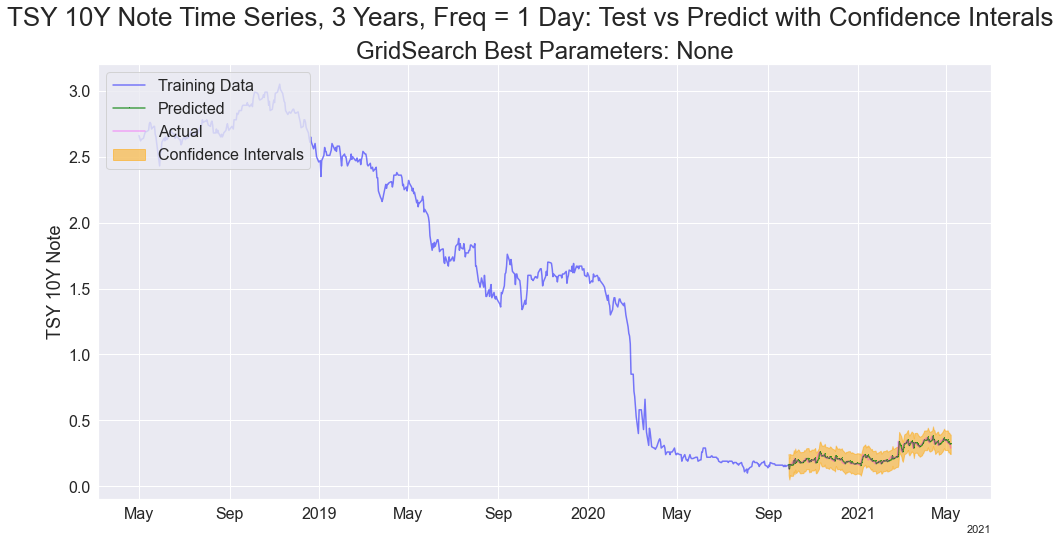

In [346]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_3Y_10Y.run_gridsearch_CV(min_order=0, max_order=3, min_d=0, max_d=0, min_p=0, min_q=0,
                                    with_intercept='auto', f_m=252, k=2, #t_list=['c','n'],
                                    fourier=False, box=False, log=False, debug=False, verbose=1, parallel=False)

In [345]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_3Y_10Y.run_gridsearch_CV(min_order=0, max_order=3, min_d=0, max_d=0, min_p=0, min_q=0,
                                    with_intercept='auto', f_m=252, k=2, #t_list=['c','n'],
                                    fourier=False, box=False, log=False, debug=False, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

AssertionError: Based on parameters given, 0 models built out of 40 in grid, terminating.

NameError: name 'func' is not defined

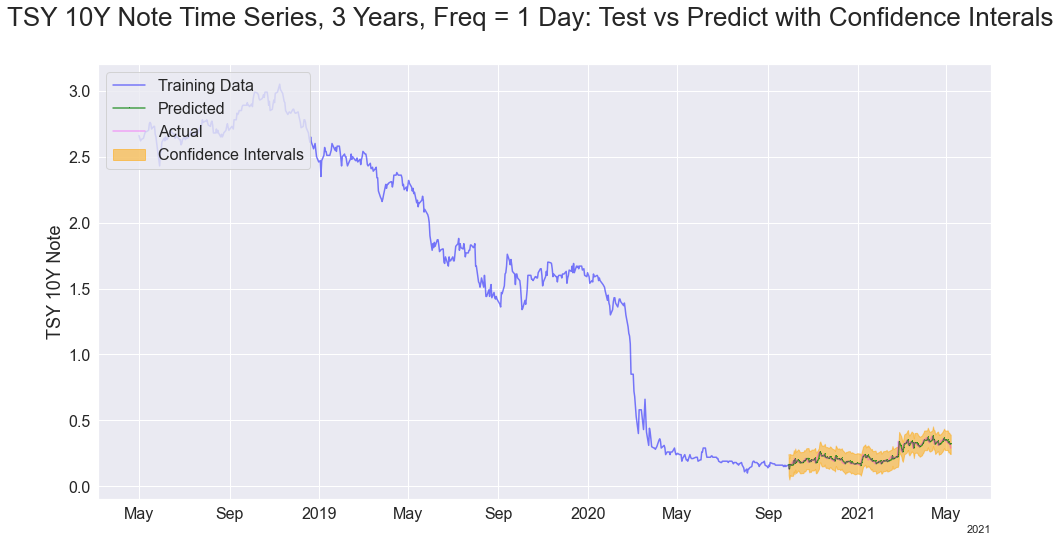

In [330]:
func = 'GS'

conf = ''
ylabel = pam_tsy_3Y_10Y.data_name
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pam_tsy_3Y_10Y.X_train, pam_tsy_3Y_10Y.y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(pam_tsy_3Y_10Y.X_test, pam_tsy_3Y_10Y.y_hat, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(pam_tsy_3Y_10Y.X_test, pam_tsy_3Y_10Y.y_test, color='magenta', alpha=0.3, label='Actual')

conf = '_Conf'
conf_int = np.asarray(pam_tsy_3Y_10Y.conf_ints)
ax.fill_between(pam_tsy_3Y_10Y.X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5, prop={"size":16})
fig.suptitle(f'{ylabel} Time Series, {pam_tsy_3Y_10Y.timeframe}, Freq = {pam_tsy_3Y_10Y.freq}: Test vs Predict with Confidence Interals\n', size=26)
ax.set_ylabel(ylabel, size=18)
ax.set_xlabel(ax.get_xlabel(), size=18)
tick_params = dict(size=4, width=1.5, labelsize=16)
ax.tick_params(axis='y', **tick_params)
ax.tick_params(axis='x', **tick_params)
if func == 'AA':
    ax.set_title(f'AutoARIMA Best Parameters: {pam_tsy_3Y_10Y.AA_best_params}', size=24)
    plt.savefig(f'{TOP}/images/AutoArima/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')
elif func == 'GS':
    ax.set_title(f'GridSearch Best Parameters: {pam_tsy_3Y_10Y.GS_best_params}', size=24)
    plt.savefig(f'{TOP}/images/GridSearch/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')
else:
    ax.set_title(f'Parameters: {pam_tsy_3Y_10Y.mod_params}', size=24)
    plt.savefig(f'{TOP}/images/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')

In [340]:
mod_file = open(pkl_filepath,'rb')
mod_data = pkl.load(mod_file)
mod_file.close()
mod_data[2]

,ARIMA_Order,Diffs,Mod_Order,Trend,Intercept,Date,Fourier,Fourier_m,Fourier_k,BoxCox,Log,Scored,AIC,RMSE,RMSE%,SMAPE,CV_Time
Model,,,,,,,,,,,,,,,,,
0,"(2, 0, 0)",0,2,c,True,True,False,None,None,False,False,True,-2799.9381,0.0185,1.0714,5.6428,68.8024


#### All Years

In [ ]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='t',
               n='All', periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=True, box=False, log=False)

Explict model pipe passed: 
       ARIMA_Order  Diffs  Mod_Order Trend Intercept  Date  Fourier  Fourier_m  \
Model                                                                           
0       (0, 1, 0)      1          0     t      auto  True     True        252   

       Fourier_k  BoxCox    Log  Scored   AIC  RMSE RMSE% SMAPE CV_Time  
Model                                                                    
0              4   False  False   False  None  None  None  None    None  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Starting step-wise cross-validation on adhoc model....
Iteratively making predictions on TSY 10Y Note Time Series and updating model, beginning with first index of y_test ...


> 
>_

Done.
Test AIC: -20484.799
Test RMSE: 0.043
This is 0.962% of the avg observed value.
Test SMAPE: 2.015%

Attempting to add a new score to file... Model not already present in file. Appending model scores to file. int64 float64 



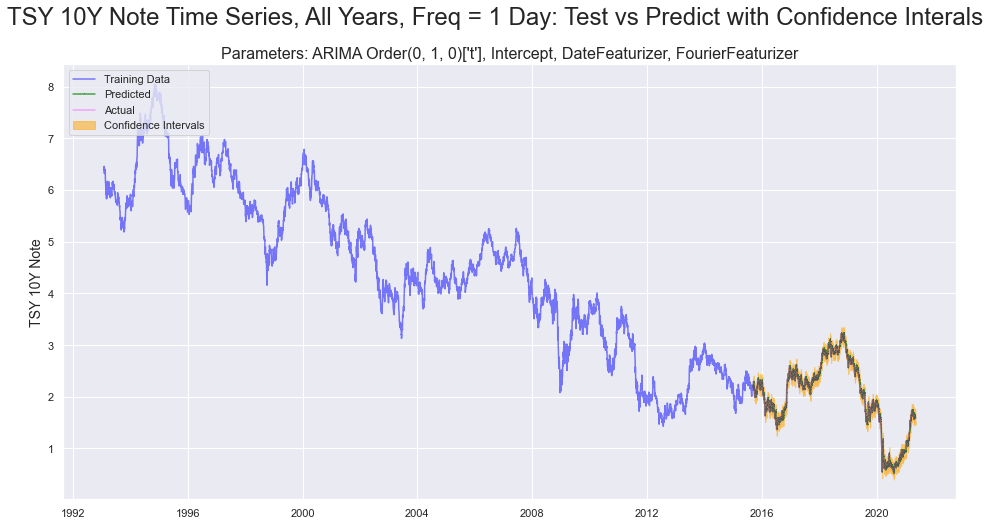

In [242]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(func='adhoc', dynamic=False, verbose=1, visualize=True)

Starting AutoARIMA...
Data set diffs to use: 1


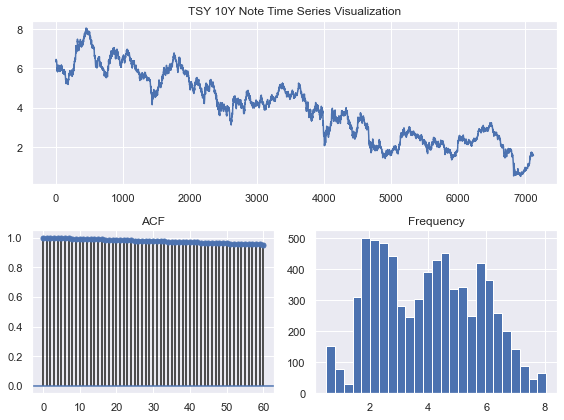

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15830.010, Time=30.68 sec
First viable model found (-15830.010)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15829.618, Time=10.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15829.105, Time=12.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15829.211, Time=11.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15830.769, Time=15.14 sec
New best model found (-15830.769 < -15830.010)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15828.644, Time=19.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 100.756 seconds
Saved best AutoARIMA model as /Users/wax/Documents/Class

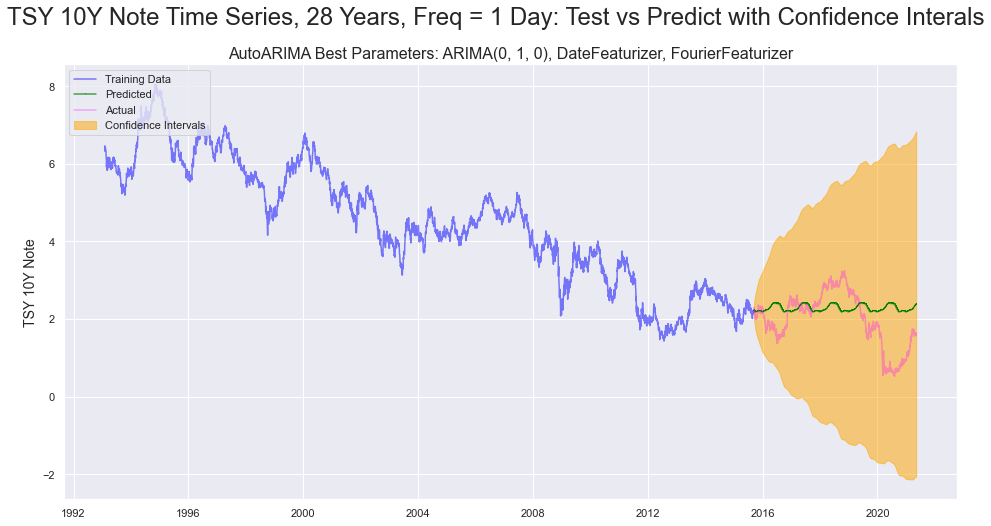

In [113]:
pam_tsy_all_10Y_AA_pipe = pam_tsy_all_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(0, 1, 0), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on TSY 10Y Note Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: -20523.139
Test RMSE: 0.043
This is 0.962% of the avg observed value.
Test SMAPE: 2.014%




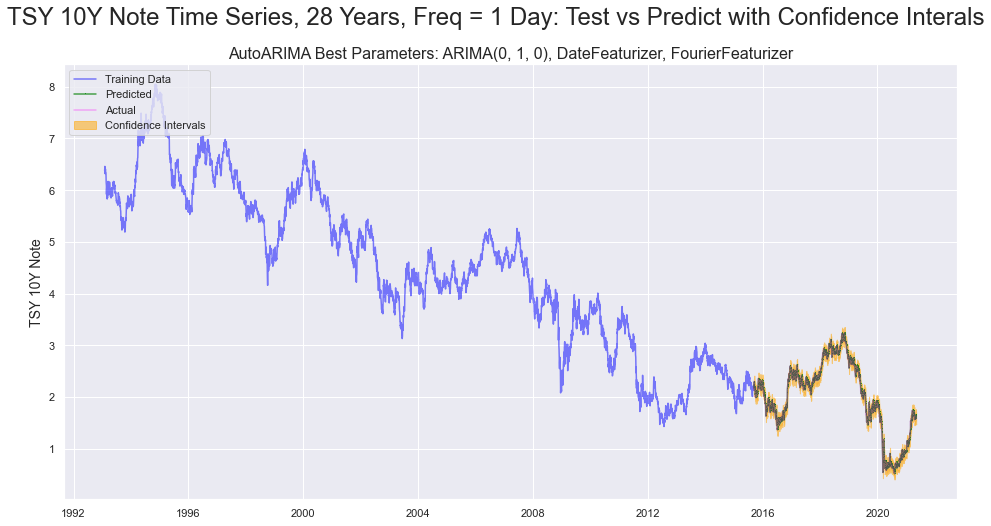

In [119]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [157]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_all_10Y.run_gridsearch_CV(min_order=0, max_order=0, min_d=0, max_d=0, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', f_m=252, # k=2,
                                    fourier=False, box=False, log=False, debug=False, verbose=0, parallel=False)

Starting GridSearchCV...
Running normally.


________________________________________________________________________

Starting step-wise cross-validation...


> 


KeyboardInterrupt: 

### Fed Funds

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['t'], Interce

________________________________________________________________________

Running step-wise cross-validation on model 1 of 12... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 5869.894 | RMSE: 0.973 | RMSE%=170.255% | SMAPE 130.653%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=5869.894 | RMSE=0.973 | RMSE_pc=170.255% | SMAPE=130.653%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=0.973
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 0.
Adding scores to model, updating line 0.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 12... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 5710.865 | RMSE: 1.127 | RMSE%=197.281% | SMAPE 115.204%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=5710.865 | RMSE=1.127 | RMSE_pc=197.281% | SMAPE=115.204%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 12... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 6803.435 | RMSE: 1.264 | RMSE%=221.310% | SMAPE 113.626%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=6803.435 | RMSE=1.264 | RMSE_pc=221.310% | SMAPE=113.626%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 12... 
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 5867.889 | RMSE: 0.973 | RMSE%=170.371% | SMAPE 130.708%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['n'], DateFeaturizer]: AIC=5867.889 | RMSE=0.973 | RMSE_pc=170.371% | SMAPE=130.708%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 12... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 2555.228 | RMSE: 0.528 | RMSE%=92.478% | SMAPE 92.918%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=2555.228 | RMSE=0.528 | RMSE_pc=92.478% | SMAPE=92.918%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=0.528
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 12... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 2340.773 | RMSE: 0.625 | RMSE%=109.453% | SMAPE 100.326%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=2340.773 | RMSE=0.625 | RMSE_pc=109.453% | SMAPE=100.326%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 12... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 5752.140 | RMSE: 0.880 | RMSE%=154.079% | SMAPE 107.631%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=5752.140 | RMSE=0.880 | RMSE_pc=154.079% | SMAPE=107.631%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 12... 
ARIMA Order(0, 0, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 2552.856 | RMSE: 0.530 | RMSE%=92.794% | SMAPE 93.014%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer]: AIC=2552.856 | RMSE=0.530 | RMSE_pc=92.794% | SMAPE=93.014%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 12... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10458.485 | RMSE: 0.051 | RMSE%=8.877% | SMAPE 4.508%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-10458.485 | RMSE=0.051 | RMSE_pc=8.877% | SMAPE=4.508%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=0.051
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 12... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9805.654 | RMSE: 0.051 | RMSE%=8.928% | SMAPE 7.049%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=-9805.654 | RMSE=0.051 | RMSE_pc=8.928% | SMAPE=7.049%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 12... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9794.320 | RMSE: 0.051 | RMSE%=8.945% | SMAPE 7.166%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9794.320 | RMSE=0.051 | RMSE_pc=8.945% | SMAPE=7.166%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 12... 
ARIMA Order(1, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10461.837 | RMSE: 0.051 | RMSE%=8.870% | SMAPE 4.349%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=-10461.837 | RMSE=0.051 | RMSE_pc=8.870% | SMAPE=4.349%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=0.051
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=-10461.837 | RMSE=0.051 | RMSE%=8.870% | SMAPE=4.349%
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-10458.485 | RMSE=0.051 | RMSE%=8.877% | SMAPE=4.508%
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=-9805.654 | RMSE=0.051 | RMSE%=8.928% | SMAPE=7.049%
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9794.320 | RMSE=0.051 | RMSE%=8.945% | SMAPE=7.166%
Model[ARIMA Order(0, 0, 1)['c'], In

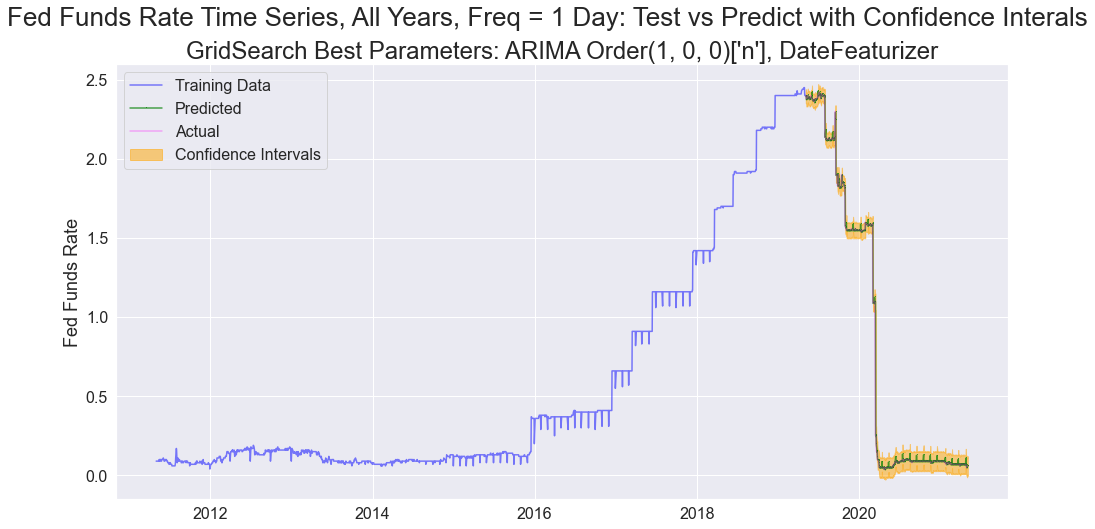

In [347]:
pam_fed_funds_10Y = Pmdarima_Model(fed_10Y_df, 'Fed Funds Rate', order=(0,1,0), trend='t',
               n='All', periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=0, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

In [ ]:
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=2, min_d=0, max_d=0, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

________________________________________________________________________

Running step-wise cross-validation on model 1 of 12... 
ARIMA Order(0, 0, 2)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -313.209 | RMSE: 0.290 | RMSE%=50.739% | SMAPE 67.230%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['c'], Intercept, DateFeaturizer]: AIC=-313.209 | RMSE=0.290 | RMSE_pc=50.739% | SMAPE=67.230%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 12... 
ARIMA Order(0, 0, 2)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 1958.783 | RMSE: 0.596 | RMSE%=104.335% | SMAPE 99.438%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['t'], Intercept, DateFeaturizer]: AIC=1958.783 | RMSE=0.596 | RMSE_pc=104.335% | SMAPE=99.438%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 12... 
ARIMA Order(0, 0, 2)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4362.798 | RMSE: 0.807 | RMSE%=141.308% | SMAPE 105.321%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['ct'], Intercept, DateFeaturizer]: AIC=4362.798 | RMSE=0.807 | RMSE_pc=141.308% | SMAPE=105.321%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 12... 
ARIMA Order(0, 0, 2)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -314.871 | RMSE: 0.293 | RMSE%=51.337% | SMAPE 67.725%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['n'], DateFeaturizer]: AIC=-314.871 | RMSE=0.293 | RMSE_pc=51.337% | SMAPE=67.725%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 12... 
ARIMA Order(1, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10469.378 | RMSE: 0.051 | RMSE%=8.995% | SMAPE 4.359%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=-10469.378 | RMSE=0.051 | RMSE_pc=8.995% | SMAPE=4.359%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 12... 
ARIMA Order(1, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -4401.769 | RMSE: 0.161 | RMSE%=28.152% | SMAPE 45.588%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=-4401.769 | RMSE=0.161 | RMSE_pc=28.152% | SMAPE=45.588%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 12... 
ARIMA Order(1, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9595.072 | RMSE: 0.054 | RMSE%=9.399% | SMAPE 6.280%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=-9595.072 | RMSE=0.054 | RMSE_pc=9.399% | SMAPE=6.280%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 12... 
ARIMA Order(1, 0, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


## TBATS

In [40]:
if __name__ == '__main__':
    tb = tbats.TBATS(seasonal_periods=(3*30.436875, 365.25))
    tb

In [75]:
# X_train, X_test, y_train, y_test = train_test_split(spy_df_3Y.close, test_size = .20, random_state = 729)
train, test = train_test_split_data(spy_df_10Y.close, train_size = 80)
train, test

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2019-05-02    291.179993
 2019-05-03    294.029999
 2019-05-06    292.820007
 2019-05-07    287.929993
 2019-05-08    287.529999
 Name: close, Length: 2018, dtype: float64,
 date
 2019-05-09    286.660004
 2019-05-10    288.100006
 2019-05-13    280.859985
 2019-05-14    283.399994
 2019-05-15    285.059998
                  ...    
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 2021-05-06    419.070007
 2021-05-07    422.119995
 Name: close, Length: 504, dtype: float64)

In [76]:
tb_mod = tb.fit(train)

In [77]:
y_hat, conf_ints = tb_mod.forecast(steps=152, confidence_level=0.95)

# Print mean absolute errors
print('MAE (in sample)', np.mean(np.abs(tb_mod.resid)))
print('MAE (forecast)', np.mean(np.abs(y_hat - test)))

ylabel='SPY_Close_TBATS'
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train, color='blue', alpha=0.5, label='Training Data')
ax.plot(test.index, y_hat, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(test, color='magenta', alpha=0.3, label='Actual')
if conf_ints:
    conf_int = np.asarray(conf_ints)
    ax.fill_between(test.index,
             conf_ints['upper_bound'], conf_ints['lower_bound'],
             alpha=0.5, color='orange',
             label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=24)
ax.set_ylabel(ylabel, size=14)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..
MAE (in sample) 1.2088346772288139


ValueError: operands could not be broadcast together with shapes (152,) (504,) 

## Logistic Regression

In [56]:
y_forecasted = tb_mod.forecast(steps=14)

In [57]:
y_forecasted

array([334.17013971, 333.20464908, 332.81299236, 332.96132464,
       332.88464521, 332.91194596, 332.89888889, 332.90382327,
       332.90157546, 332.90245771, 332.90206794, 332.90222464,
       332.90215674, 332.90218446])

### SPY vs SPY Future - no offset¶

In [76]:
X, y = create_data_sets(spy_f_df_3Y, spy_df_3Y, verbose=1)

regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
X:
              f_open   f_high    f_low  f_close  f_adj_close   f_volume  change
date                                                                          
2018-05-01  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0       0
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0       0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0       0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0       1
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0       1
...             ...      ...      ...      ...          ...        ...     ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0       1
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0       0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0  

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test[0]

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,change
date,,,,,,,
2018-12-12,2632.500,2686.50,2631.75,2652.50,2652.50,1900862.0,1
2018-10-01,2922.500,2942.00,2922.50,2930.00,2930.00,1239963.0,1
2020-12-24,3678.125,3717.00,3663.50,3704.50,3704.50,891236.5,1
2021-04-21,4121.250,4167.25,4113.00,4164.75,4164.75,1505474.0,1
2019-02-05,2719.500,2737.75,2716.25,2731.00,2731.00,1225737.0,1
...,...,...,...,...,...,...,...
2018-06-18,2780.000,2786.75,2761.25,2779.75,2779.75,993118.0,0
2020-06-15,2992.750,3079.25,2935.00,3073.00,3073.00,1947459.0,1
2019-04-02,2868.500,2873.75,2862.25,2867.00,2867.00,859942.0,1


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume',
       'change'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        n

{'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  7
Model score:  1.0
Accuracy score:  1.0
Model F1 (micro):  1.0
Model F1 (macro):  1.0
Model F1 (weighted):  1.0
Cross validation score:  [1. 1. 1. 1. 1.]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        89

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



NameError: name 'best_estimator' is not defined

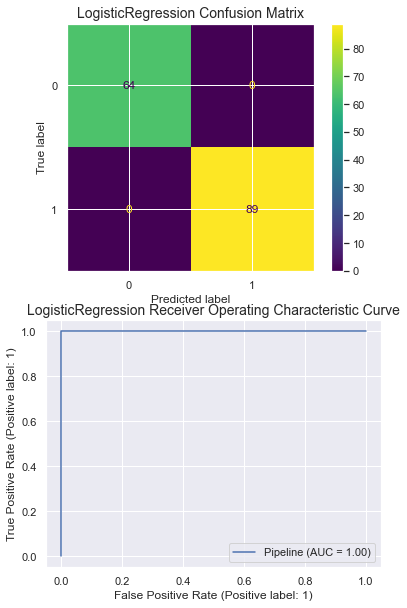

In [78]:
model, y_hat = run_model_gridsearch_CV(X_y_train_test, clf_type='log', verbose=1)

In [146]:
X = spy_cat_3Y_df.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
# y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
2018-05-08  2668.00  2674.25  2652.25  2670.25      2670.25  1281751.0
...             ...      ...      ...      ...          ...        ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0
2021-05-06  4158.75  4197.25  4140.50  4194.25      4194.25  1751616.0
2021-05-07  4197.50  4232.25  4191.75  4225.25      4225.25  1751616.0

[760 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


### SPY vs SPY Future - one day offset

In [79]:
test = [False]
if test:
    print(True)

Pmdarima_Model.py loaded from {top}/data..
regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
True


In [165]:
y_setup = df_1d_back.copy()
y_setup['close_diff'] = y_setup.close.diff()
y_setup['change'] = np.where(y_setup.close_diff >= 0, 1, 0)
y_setup

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume,close_diff,change
date,,,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,-1.779999,0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,-0.580017,0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,3.399994,1
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,0.900024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4129.00,4186.75,4127.50,4171.50,4171.50,1509514.0,0.869995,1
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0,-0.089996,0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0,-0.119995,0


In [167]:
X = df_1d_back.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0
2018-05-03  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-04  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-07  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-08  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
...             ...      ...      ...      ...          ...        ...
2021-04-26  4129.00  4186.75  4127.50  4171.50      4171.50  1509514.0
2021-04-27  4170.75  4186.00  4163.75  4179.50      4179.50  1019731.0
2021-04-28  4181.50  4192.50  4166.75  4179.00      4179.00   992029.0
2021-04-29  4180.25  4193.75  4172.75  4176.25      4176.25  1282972.0
2021-04-30  4184.75  4211.00  4168.00  4203.50      4203.50  1746965.0

[783 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


In [168]:
y.isna().sum()

0

In [169]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
])
                
# categorical_pipeline = Pipeline(steps=[
#     ('ohe', OneHotEncoder( #drop='first',
#                          sparse=False,
#                          handle_unknown='ignore'))
# ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train.columns),
#     ('categorical', categorical_pipeline, X_train.columns)
])


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



{'lr__C': 1.623776739188721, 'lr__class_weight': 'none', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Classifier:  LogisticRegression
Num features:  6
Model score:  0.5605095541401274
Accuracy score:  0.5605095541401274
Model F1 (micro):  0.5605095541401274
Model F1 (macro):  0.3591836734693878
Model F1 (weighted):  0.4026517613414793
Cross validation score:  [0.59375    0.59375    0.41935484 0.5483871  0.58064516]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.56      1.00      0.72        88

    accuracy                           0.56       157
   macro avg       0.28      0.50      0.36       157
weighted avg       0.31      0.56      0.40       157



/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

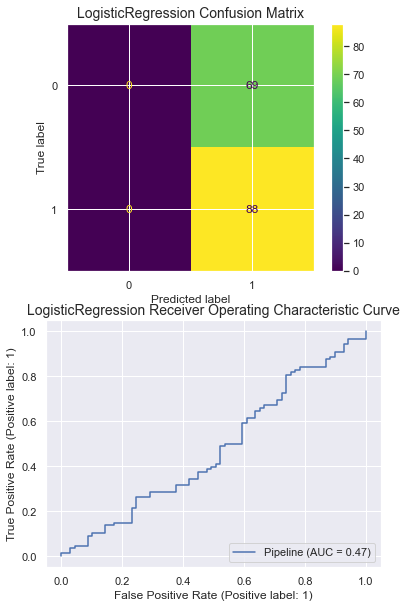

In [180]:
pipe_lr = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(random_state=1, max_iter=500))
])
print(pipe_lr)

params_grid_lr = {'lr__penalty' : ['l1', 'l2','elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=4, n_jobs=-1)

lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, binary=True)
Audio(sound_file, autoplay=True)

# Forecasting

## PmdArima

## All Years, 10 Year Treasury Note

In [ ]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='c', with_intercept=False,
               n='All', periods='years', freq='1 Day', f_seas=252*4, k=2, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, 
               date=True, fourier=True, box=False, log=False)

In [246]:
pam_tsy_all_10Y_best = pam_tsy_3Y_10Y_best

In [247]:
tsy_all_10Y_hat_df, tsy_all_10Y_hat, new_dates_df, tsy_all_10Y_conf_ints = pam_tsy_all_10Y.run_prediction(pam_tsy_all_10Y_best, 52, fin=False,
                            en_ex='exog', func='adhoc', verbose=1, visualize=True)

NameError: name 'df' is not defined

## Linear